In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_48/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>

# Series de Tiempo - Checkpoint

<br/> 

<div id="caja11" style="float:left;width: 100%;">
  <div style="float:left;width: 9%;"><img src="../../../common/icons/haciendo_foco.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;">
      <label>Vamos a poner en práctica lo aprendido en la notebook de práctica guiada.</label>
  <div style="float:left;width: 85%;">
      <label>Es importante que antes de la clase resuelvan esta notebook ya que es fundamental que sepan utilizar las herramientas que vimos en la práctica guiada para después trabajar el caso práctico en la clase.</label>        
</div>    
</div>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

from checkpoint_series_tiempo import *

#### Pongamos en práctica las herramientas que vimos en la práctica guiada: 

En este caso, nuestra variable de interés el el precio de la cebolla en India. Contamos con un dataset con información desagregada por ciudad. 

In [3]:
df = pd.read_csv('../Data/cebolla_india.csv')
df.shape

(10227, 10)

In [4]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


El dataset tiene tres columnas (features o variables) sobre la ubicación del mercado mayorista donde se vendió cebolla:

* **state**: esta es la abreviatura de 2/3 letras para el estado en India (PB es Punjab, etc.)
* **ciudad**: esta es la ciudad en India (ABOHAR, BANGALORE y así sucesivamente)
* **mercado**: esta es una cadena con la combinación del estado y la ciudad

Tres están relacionados con la fecha de la transacción: 

* **mes**: mes en enero, febrero y así sucesivamente
* **año**: año (YYYY)
* **fecha**: la combinación de los dos anteriores

Cuatro son acerca de la cantidad y el precio en este mercado mayorista (todas numéricas).

* **cantidad**: la cantidad de cebolla que llega al mercado en ese mes en quintales (100 kg)
* **priceMin**: el precio mínimo en el mes en Rs./quintal
* **priceMax**: el precio máximo en el mes en Rs./quintal
* **priceMod**: el precio modal en el mes en Rs./quintal

Fijate de qué tipo son las columnas del DataFrame:

In [5]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df.dtypes

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object

Podés observar que "date" es un object. Transformala a un datetime:

In [6]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

df['date'] = pd.to_datetime(df['date'])

df['date'].dtype

dtype('<M8[ns]')

Vamos a analizar el volumen de ventas por ciudad. Hacé un groupby por ciudad y sumá las cantidades vendidas ('quantity'):

In [7]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df.groupby('city')['quantity'].sum().sort_values(ascending=False).head()

city
BANGALORE     76491944
PUNE          59470570
LASALGAON     58765209
PIMPALGAON    53231396
DELHI         46305615
Name: quantity, dtype: int64

Vamos a restringir nuestro análisis solamente a la ciudad de Bangalore. Generá un DataFrame nuevo conservando solamente a la serie de tiempo de Bangalore:

In [8]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
dfBang = df.loc[df.city == 'BANGALORE'].copy()

Hacé un sort del DataFrame para que las observaciones queden ordenadas en el tiempo:

In [9]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
dfBang = dfBang.sort_values(by = "date")

Reindexá el DataFrame para que el index sea "date" con frecuencia mensual:

In [10]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
dfBang.index = pd.PeriodIndex(dfBang.date, freq='M')
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


Vamos a definir una función que plotea series de tiempo:

In [11]:
# Función que plotea la serie:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

Vamos a trabajar usando la serie **priceMod**.

Usá la función que acabamos de definir para plotear 'priceMod'. Recordá que las x tienen que tener un formato de datetime. 

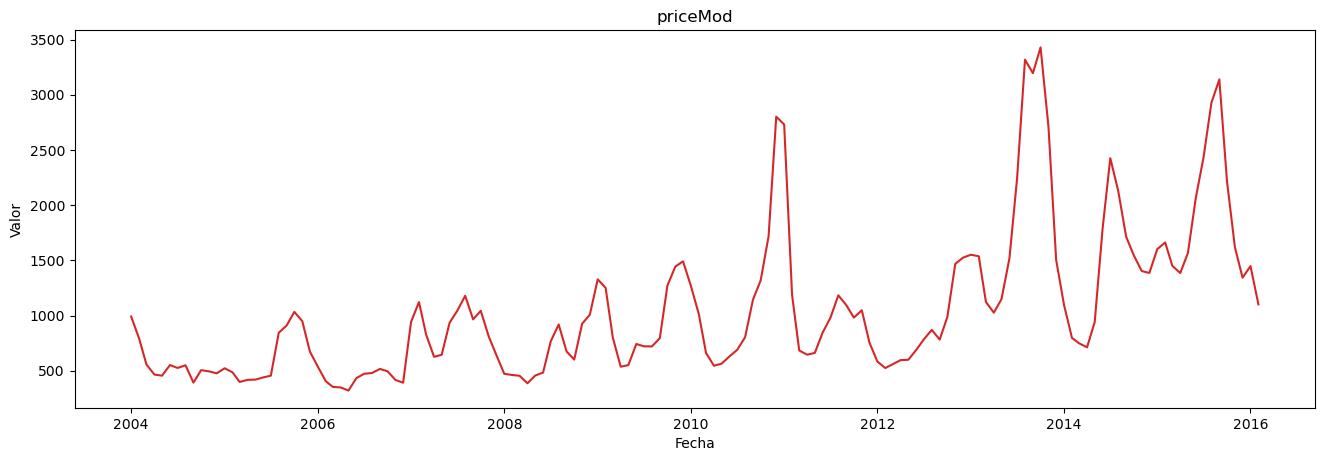

In [12]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
plot_df(dfBang, x=dfBang.date, y=dfBang.priceMod, title="priceMod")

Ahora creá una dummy de tiempo para modelar la tendencia lineal:

In [13]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

dfBang["timeIndex"] = pd.Series(np.arange(len(dfBang['priceMod'])), index=dfBang.index)

dfBang.head()

# Comentario: recordá que la dummy de tiempo es una variable de apoyo que lleva la cuenta de
# la cantidad de periodos que pasan desde la primera observación. Sirve para poder hacer
# regresiones contra el tiempo y estimar la tendencia. 

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,timeIndex
date,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,0
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,1
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,2
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,3
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,4


In [14]:
dfBang.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,timeIndex
date,,,,,,,,,,,
2015-10,BANGALORE,October,2015,1612160,385,3365,2215,KNT,BANGALORE,2015-10-01,141
2015-11,BANGALORE,November,2015,1071872,205,3138,1618,KNT,BANGALORE,2015-11-01,142
2015-12,BANGALORE,December,2015,513186,217,2030,1343,KNT,BANGALORE,2015-12-01,143
2016-01,BANGALORE,January,2016,507223,200,1943,1448,KNT,BANGALORE,2016-01-01,144
2016-02,BANGALORE,February,2016,400359,200,1505,1101,KNT,BANGALORE,2016-02-01,145


Ahora creá las dummies de mes y hacé el join con el DataFrame.

In [15]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
dummies_mes = pd.get_dummies(dfBang['month'], drop_first=True)
dfBang =  dfBang.join(dummies_mes)
dfBang.sample(10)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2010-12,BANGALORE,December,2010,662016,2377,3290,2802,KNT,BANGALORE,2010-12-01,...,1,0,0,0,0,0,0,0,0,0
2009-07,BANGALORE,July,2009,335728,512,886,721,KNT,BANGALORE,2009-07-01,...,0,0,0,1,0,0,0,0,0,0
2010-10,BANGALORE,October,2010,1059835,1050,1455,1318,KNT,BANGALORE,2010-10-01,...,0,0,0,0,0,0,0,0,1,0
2006-03,BANGALORE,March,2006,337968,224,371,353,KNT,BANGALORE,2006-03-01,...,0,0,0,0,0,1,0,0,0,0
2012-02,BANGALORE,February,2012,363037,185,696,524,KNT,BANGALORE,2012-02-01,...,0,1,0,0,0,0,0,0,0,0
2013-04,BANGALORE,April,2013,377960,579,1213,1026,KNT,BANGALORE,2013-04-01,...,0,0,0,0,0,0,0,0,0,0
2007-06,BANGALORE,June,2007,264983,845,1004,935,KNT,BANGALORE,2007-06-01,...,0,0,0,0,1,0,0,0,0,0
2004-08,BANGALORE,August,2004,251984,476,621,549,KNT,BANGALORE,2004-08-01,...,0,0,0,0,0,0,0,0,0,0
2016-02,BANGALORE,February,2016,400359,200,1505,1101,KNT,BANGALORE,2016-02-01,...,0,1,0,0,0,0,0,0,0,0


Hacé el split entre train y test dejando los últimos 12 meses en el set de testeo. Luego corroborá la continuidad entre el set de entrenamiento y de testeo. 

In [16]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train, df_test = train_test_split(dfBang, test_size=12, random_state=42, shuffle=False)

In [17]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2014-10,BANGALORE,October,2014,1412686,605,2037,1546,KNT,BANGALORE,2014-10-01,...,0,0,0,0,0,0,0,0,1,0
2014-11,BANGALORE,November,2014,1235389,145,2309,1403,KNT,BANGALORE,2014-11-01,...,0,0,0,0,0,0,0,1,0,0
2014-12,BANGALORE,December,2014,842653,312,2212,1386,KNT,BANGALORE,2014-12-01,...,1,0,0,0,0,0,0,0,0,0
2015-01,BANGALORE,January,2015,583681,313,1967,1602,KNT,BANGALORE,2015-01-01,...,0,0,1,0,0,0,0,0,0,0
2015-02,BANGALORE,February,2015,405716,609,2018,1662,KNT,BANGALORE,2015-02-01,...,0,1,0,0,0,0,0,0,0,0


In [18]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2015-03,BANGALORE,March,2015,443687,638,1660,1450,KNT,BANGALORE,2015-03-01,...,0,0,0,0,0,1,0,0,0,0
2015-04,BANGALORE,April,2015,468522,552,1564,1385,KNT,BANGALORE,2015-04-01,...,0,0,0,0,0,0,0,0,0,0
2015-05,BANGALORE,May,2015,420072,413,1904,1567,KNT,BANGALORE,2015-05-01,...,0,0,0,0,0,0,1,0,0,0
2015-06,BANGALORE,June,2015,485652,940,2356,2068,KNT,BANGALORE,2015-06-01,...,0,0,0,0,1,0,0,0,0,0
2015-07,BANGALORE,July,2015,505717,1192,2800,2432,KNT,BANGALORE,2015-07-01,...,0,0,0,1,0,0,0,0,0,0


Creá las transformaciones logarítmicas de priceMod tanto para el set de entrenamiento como para el set de testeo.

In [19]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train['log_value'] = np.log(df_train['priceMod'])
df_test['log_value'] = np.log(df_test['priceMod'])

Ploteá la serie logarítmica:

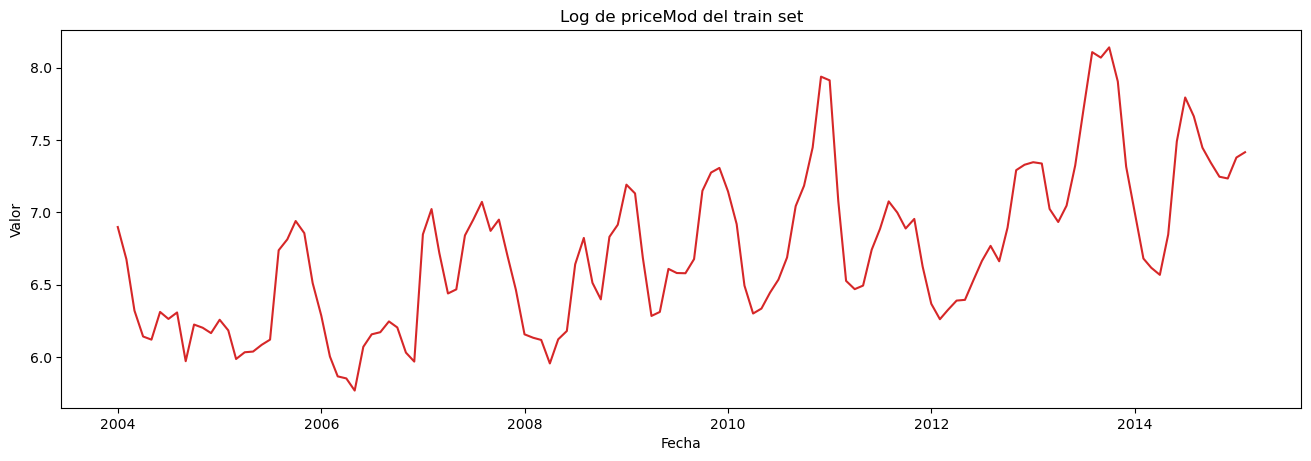

In [20]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
plot_df(df_train, x=df_train.date, y=df_train['log_value'],\
    title='Log de priceMod del train set')

Vemos que la dispersión de la serie se estabilizó significativamente en t. 

Ahora entrená un modelo lineal entre la serie transformada y la dummy de tiempo y analizá el summary.

In [21]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
model_log = smf.ols('log_value ~ timeIndex',\
                          data = df_train).fit()

In [22]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     97.58
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           1.44e-17
Time:                        21:38:14   Log-Likelihood:                -67.913
No. Observations:                 134   AIC:                             139.8
Df Residuals:                     132   BIC:                             145.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1280      0.070     88.132      0.000       5.990       6.266
timeIndex      0.0089      0.001      9.878      0.000       0.007       0.011
==============================================================================
Omnibus:                        5.041   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.129
Skew:                           0.455   Prob(JB):                       0.0770
Kurtosis:                       2.702   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Agregá las predicciones del modelo en el set de entrenamiento y de testeo con y sin back-transformation:

In [23]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

In [24]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

Ploteá las predicciones vs. las series reales, tanto en el set de entrenamiento como en el de testeo.

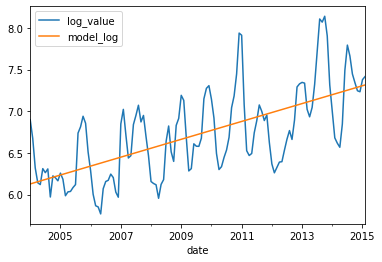

In [25]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train.plot(kind = "line", x = "date", y = ['log_value', 'model_log']);

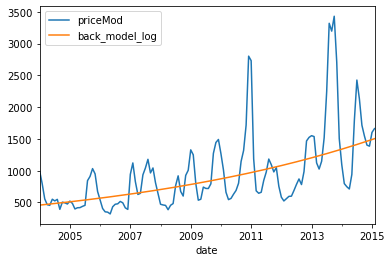

In [26]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train.plot(kind = "line", x = "date", y = ['priceMod', 'back_model_log']);

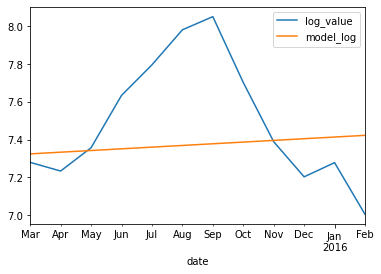

In [27]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", x = "date", y = ['log_value', 'model_log']);

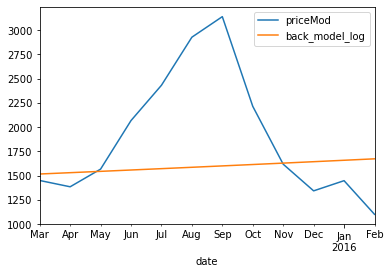

In [28]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", x = "date", y = ['priceMod', 'back_model_log']);

Creamos la función para calcular el RMSE:

In [29]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

Guardá el resultado en un DataFrame:

In [30]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Log"
df_Results.loc[0, "RMSE"] = RMSE(df_test.back_model_log, df_test.priceMod)
df_Results

,Model,RMSE
0,Log,708.283


Ahora entrená un modelo agregando variables de estacionalidad mensual y agregá el RMSE en el DataFrame de resultados. 

In [31]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

model_log_est = smf.ols('log_value ~ timeIndex + August + December + February + January + July + November+ October + September',\
                          data = df_train).fit()

# Recordá que tenés que agregar a la función de regresión los nombres de las dummies
# mensuales que agregamos antes. Recordá también que dropeamos un mes, por lo cual no lo 
# tenés que incluir en la expresión de la regresión. 
# En la solución no estamos incluyendo a los meses de junio, marzo y mayo porque no
# son significativos.



In [32]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     18.00
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           8.22e-19
Time:                        21:38:15   Log-Likelihood:                -49.004
No. Observations:                 134   AIC:                             118.0
Df Residuals:                     124   BIC:                             147.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8748      0.075     78.201      0.000       5.726       6.024
timeIndex      0.0086      0.001     10.646      0.000       0.007       0.010
August         0.4551      0.122      3.722      0.000       0.213       0.697
December       0.4004      0.122      3.272      0.001       0.158       0.643
February       0.2833      0.118      2.398      0.018       0.049       0.517
January        0.4539      0.118      3.843      0.000       0.220       0.688
July           0.3102      0.122      2.537      0.012       0.068       0.552
November       0.4967      0.122      4.060      0.000       0.255       0.739
October        0.4670      0.122      3.818      0.000       0.225       0.709
September      0.3844      0.122      3.143      0.002       0.142       0.626
==============================================================================
Omnibus:                        3.338   Durbin-Watson:                   0.422
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.378
Skew:                           0.368   Prob(JB):                        0.185
Kurtosis:                       2.750   Cond. No.                         477.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Comentario: recordá que podés usar el método precict del modelo para realizar predicciones.
Al método le tenés que pasar el DataFrame y especificar las columnas a incluir. 

Hacé las predicciones en el set de entrenamiento y testo y almacená los resultados en ambos DataFrames:

In [33]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:



df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex",\
                                              "August", "December", "February", "January",\
                                               "July","November", "October", "September"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex",\
                                              "August", "December", "February", "January",\
                                               "July","November", "October", "September"]])

Comentario: recordá que para hacer back transformation de una transformación logarítmica tenés que usar la función exponencial. 

Almacená en tus DataFrames los modelos con back transformation. 

In [34]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

Plotea el modelo con y sin back transformation para el set de entrenamiento:

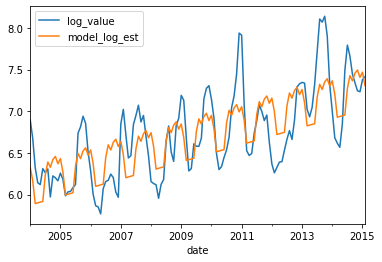

In [35]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train.plot(kind = "line", x = "date", y = ['log_value', 'model_log_est']);

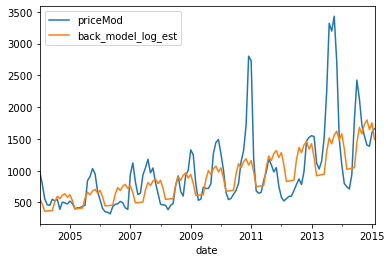

In [36]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train.plot(kind = "line", x = "date", y = ['priceMod', 'back_model_log_est']);

Plotea el modelo con y sin back transformation para el set de testeo:

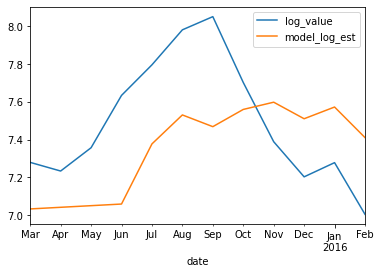

In [37]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", x = "date", y = ['log_value', 'model_log_est']);

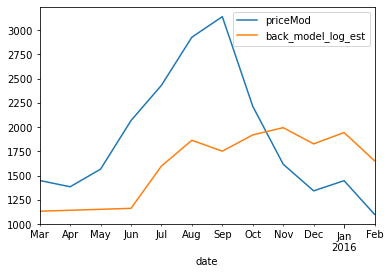

In [38]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", x = "date", y = ['priceMod', 'back_model_log_est']);

Calculá el RMSE del modelo con transformación logarítmica y estacionalidad mensual y agregala al DataFrame de resultados: 

In [39]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_Results.loc[1, "Model"] = "Log + Est"
df_Results.loc[1, "RMSE"] = RMSE(df_test.back_model_log_est, df_test.priceMod)
df_Results

,Model,RMSE
0,Log,708.283
1,Log + Est,702.169
